In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from topolib import gda_lib
import ipyvolume as ipv
import datashader as shader
import json

In [2]:
import pdal

In [3]:
import matplotlib.pyplot as plt

# specialty modules
import h5py
import pyproj
# utility modules
import glob
import os
import sys
import re

In [4]:
sample_atl03 = '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt1l_xyz_conf.laz'

In [5]:
sample_las = '/home/jovyan/sample_point_cloud.las'

In [110]:
! pdal info $sample_las --summary

{
  "file_size": 117458521,
  "filename": "/home/jovyan/sample_point_cloud.las",
  "now": "2020-06-18T04:43:16+0000",
  "pdal_version": "2.1.0 (git-version: 4676a9)",
  "reader": "readers.las",
  "summary":
  {
    "bounds":
    {
      "maxx": 564095.4945,
      "maxy": 5116850.73,
      "maxz": 2518.157871,
      "minx": 561072.9007,
      "miny": 5115291.694,
      "minz": 1987.462703
    },
    "dimensions": "X, Y, Z, Intensity, ReturnNumber, NumberOfReturns, ScanDirectionFlag, EdgeOfFlightLine, Classification, ScanAngleRank, UserData, PointSourceId, GpsTime, Red, Green, Blue",
    "num_points": 3454632,
    "srs":
    {
      "compoundwkt": "PROJCS[\"WGS 84 / UTM zone 10N\",GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]],PROJECTION[\"Transverse_M

In [111]:
!pdal info $sample_las -p 0

{
  "file_size": 117458521,
  "filename": "/home/jovyan/sample_point_cloud.las",
  "now": "2020-06-18T04:43:21+0000",
  "pdal_version": "2.1.0 (git-version: 4676a9)",
  "points":
  {
    "point":
    {
      "Blue": 0,
      "Classification": 0,
      "EdgeOfFlightLine": 0,
      "GpsTime": 0,
      "Green": 0,
      "Intensity": 0,
      "NumberOfReturns": 0,
      "PointId": 0,
      "PointSourceId": 0,
      "Red": 0,
      "ReturnNumber": 0,
      "ScanAngleRank": 0,
      "ScanDirectionFlag": 0,
      "UserData": 0,
      "X": 561572.1924,
      "Y": 5116850.73,
      "Z": 2356.332329
    }
  },
  "reader": "readers.las"
}


In [112]:
reader_pdal = {
    "pipeline": [sample_las
    ]}

In [17]:
import json

In [18]:
pipeline = pdal.Pipeline(json.dumps(reader_pdal))

In [19]:
pipeline.validate()

True

In [20]:
points = pipeline.execute()

In [21]:
ar_points = pipeline.arrays[0]

In [22]:
ar_points

array([(561572.19237263, 5116850.72997229, 2356.33232891, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       (561573.11558178, 5116850.70846256, 2356.36187495, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       (561574.0410585 , 5116850.68928821, 2356.35673087, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       ...,
       (563815.84867259, 5115291.69358212, 2089.80413505, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       (563816.72911211, 5115291.72895773, 2089.43388916, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       (563817.61158584, 5115291.78016016, 2089.09312896, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0)],
      dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2')])

In [23]:
ar_points['Z']

array([2356.33232891, 2356.36187495, 2356.35673087, ..., 2089.80413505,
       2089.43388916, 2089.09312896])

In [70]:
ipv.quickscatter(ar_points['X'],ar_points['Y'],ar_points['Z'])

In [25]:
df = pd.DataFrame({'x':ar_points['X'],'y':ar_points['Y'],'z':ar_points['Z']})

In [26]:
import datashader.transfer_functions as tf

In [34]:
cvs = shader.Canvas(plot_width=400,plot_height=400)
agg = cvs.points(df,'x','y',shader.count('z'))
img = tf.shade(agg,cmap='inferno')

ValueError: Unknown color: 'inferno'

In [47]:
%matplotlib widget

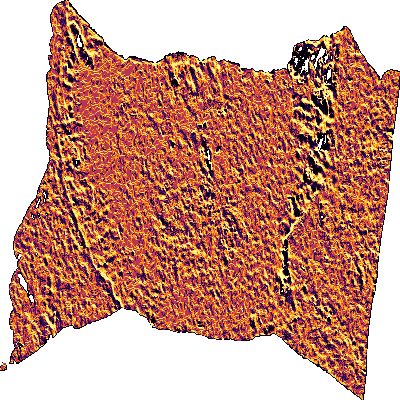

In [58]:
img

In [35]:
import hvplot
import holoviews as hv

In [41]:
x = ar_points['X']
y = ar_points['Y']
z = ar_points['Z']

In [49]:
hv.Scatter3D((x,y,z))

:Scatter3D   [x,y,z]

### Read in ATL03 from LAS

In [6]:
atl03_las = '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf.laz'

In [7]:
! pdal info --summary $atl03_las

{
  "file_size": 2337276,
  "filename": "/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf.laz",
  "now": "2020-06-18T05:48:18+0000",
  "pdal_version": "2.1.0 (git-version: 4676a9)",
  "reader": "readers.las",
  "summary":
  {
    "bounds":
    {
      "maxx": -119.497982,
      "maxy": 38.2410849,
      "maxz": 3996.239746,
      "minx": -119.5618701,
      "miny": 37.72109785,
      "minz": 448.853363
    },
    "dimensions": "X, Y, Z, Intensity, ReturnNumber, NumberOfReturns, ScanDirectionFlag, EdgeOfFlightLine, Classification, ScanAngleRank, UserData, PointSourceId, GpsTime, Red, Green, Blue",
    "num_points": 1140142
  }
}


In [126]:
! pdal info -p 322329 $atl03_las

{
  "file_size": 2337276,
  "filename": "/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf.laz",
  "now": "2020-06-18T04:48:51+0000",
  "pdal_version": "2.1.0 (git-version: 4676a9)",
  "points":
  {
    "point":
    {
      "Blue": 0,
      "Classification": 0,
      "EdgeOfFlightLine": 0,
      "GpsTime": 0,
      "Green": 0,
      "Intensity": 0,
      "NumberOfReturns": 1,
      "PointId": 322329,
      "PointSourceId": 0,
      "Red": 0,
      "ReturnNumber": 1,
      "ScanAngleRank": 0,
      "ScanDirectionFlag": 0,
      "UserData": 2,
      "X": -119.52,
      "Y": 38.09,
      "Z": 3054.24
    }
  },
  "reader": "readers.las"
}


In [7]:
outdir = '/home/jovyan/scratch/pdal_out'

## Filter based on confidence Flag
- Here, we will filter for the points based on NSIDC spec for photon confidence of 0:Noise, 1,2,3,4: background, low, medium and high confidence. 
- We will remove all the points with flag of noise, and just restrict to background to high confidence points
- pdal range filter with limit of [1:4] will do this on the UserData flag !
    

In [8]:
conf_filtered = os.path.join(outdir,os.path.splitext(os.path.basename(atl03_las))[0]+'_confidence_filter.laz')

In [129]:
conf_filtered

'/home/jovyan/scratch/pdal_out/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf_confidence_filter.laz'

In [138]:
confidence_filter = {"pipeline":[
    {
        "type":"readers.las",
        "filename":f"{atl03_las}",
        "spatialreference":"EPSG:7912"
    },
    {
            "type": "filters.range",
            "limits": "UserData[1:4]"
    },
    {
        "type":"filters.reprojection",
        "in_srs":"EPSG:7912",
        "out_srs":"EPSG:32611"
    },
    {
        "type":"writers.las",
        "compression": 'true',
        "forward": "all",
        "filename":f"{conf_filtered}"
    }
]
}

In [139]:
confidence_filter

{'pipeline': [{'type': 'readers.las',
   'filename': '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf.laz',
   'spatialreference': 'EPSG:7912'},
  {'type': 'filters.range', 'limits': 'UserData[1:4]'},
  {'type': 'filters.reprojection',
   'in_srs': 'EPSG:7912',
   'out_srs': 'EPSG:32611'},
  {'type': 'writers.las',
   'compression': 'true',
   'forward': 'all',
   'filename': '/home/jovyan/scratch/pdal_out/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf_confidence_filter.laz'}]}

In [141]:
confidence_f = pdal.Pipeline(json.dumps(confidence_filter))

In [142]:
confidence_f.validate()

True

In [143]:
confidence_f.execute()

209543

In [144]:
! pdal info $conf_filtered --summary

{
  "file_size": 321230,
  "filename": "/home/jovyan/scratch/pdal_out/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf_confidence_filter.laz",
  "now": "2020-06-18T04:53:20+0000",
  "pdal_version": "2.1.0 (git-version: 4676a9)",
  "reader": "readers.las",
  "summary":
  {
    "bounds":
    {
      "maxx": 281207.5469,
      "maxy": 4235399.593,
      "maxz": 3494.34,
      "minx": 274367.9032,
      "miny": 4177834.242,
      "minz": 1180.47
    },
    "dimensions": "X, Y, Z, Intensity, ReturnNumber, NumberOfReturns, ScanDirectionFlag, EdgeOfFlightLine, Classification, ScanAngleRank, UserData, PointSourceId, GpsTime, Red, Green, Blue",
    "num_points": 209543,
    "srs":
    {
      "compoundwkt": "PROJCS[\"WGS 84 / UTM zone 11N\",GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",

- After confidence filter, the number of points remaining are: 209543 from the initial number of 1140142

## Convert Raster to pointcloud

In [9]:
dem = '/home/jovyan/shared/data-aragon/ASO_3M_PCDTM_USCATE_20191010_20191010.tif'

In [76]:
outlas = os.path.splitext(dem)[0]+'_pointcloud.laz'

Any gdal raster can be converted to a regular pointcloud grid using pdal

In [12]:
raster2pc = {"pipeline":[
    {
        "type":"readers.gdal",
        "filename":f"{dem}"
    },
    {
        "type":"writers.las",
        "compression": 'true',
        "forward": "all",
        "filename":f"{outlas}"
    }
]
}

In [15]:
raster2pc_pipe = pdal.Pipeline(json.dumps(raster2pc))

In [16]:
raster2pc_pipe.validate()

True

In [ ]:
raster2pc_pipe.execute()

##### the kernel dies, because it quickly sips all memory.. we will skip this for now !

## Cull Pointcloud based on limits of raster 

- points can be clipped to extent of bounding box or polygon
- bounds can be specified as "([xmin, xmax], [ymin, ymax])"

In [11]:
import rasterio
dem_ds = rasterio.open(dem)

In [12]:
dem_ds.bounds

BoundingBox(left=242715.0, bottom=4178889.0, right=307584.0, top=4234848.0)

In [13]:
dem_ds.crs

CRS.from_epsg(32611)

In [14]:
xmin,ymin,xmax,ymax=dem_ds.bounds

In [15]:
clipped_las = os.path.splitext(conf_filtered)[0]+'_clipped2aso_dem.laz'

In [17]:
clip2bounds = {"pipeline":[
    {
        "type":"readers.las",
        "filename":f"{conf_filtered}"
    },
    {
        "type":"filters.crop",
        "bounds":f"([{xmin}, {xmax}], [{ymin}, {ymax}])"
    },
    {
        "type":"writers.las",
        "compression": 'true',
        "forward": "all",
        "filename":f"{clipped_las}"
    }
    
]}

In [19]:
clip2bounds_pipe = pdal.Pipeline(json.dumps(clip2bounds))

In [21]:
clip2bounds_pipe.validate()

True

In [22]:
clip2bounds_pipe.execute()

206228

- So from total remaining 209453 points, 206228 points remain !

# Filtering points

## Filtering using a gridded DEM  as reference
- PDAL can filter points based on a given height range for a pixel from a DEM
- The range of valid height values can be specified as Z[lower_bound:upper_bound]
- This will remove points which have heights lower than `lower_bound` magnitude DEM surface elevation and heights higher than `higher_bound` magnitude DEM surface elevation
- In this example we use higher and lower bounds as 100 to 100, so any point higher or lower more than 100 m from the raster DEM surface gets removed

In [23]:
dem_lower,dem_higher = [100,100]
clipped_las_aso_dem = os.path.splitext(clipped_las)[0]+'_clipped_aso_100_100.laz'

In [24]:
dem_z_filter = {"pipeline":[
    {
        "type":"readers.las",
        "filename":f"{clipped_las}"
    },
    {
        "type":"filters.dem",
        "raster":f"{dem}",
        "limits":f"Z[{dem_lower}:{dem_higher}]"
    },
    {
        "type":"writers.las",
        "compression": 'true',
        "forward": "all",
        "filename":f"{clipped_las_aso_dem}"
    }
    
]}

In [26]:
dem_z_filter_pipe = pdal.Pipeline(json.dumps(dem_z_filter))

In [27]:
dem_z_filter_pipe.validate()

True

In [28]:
dem_z_filter_pipe.execute()

101587

- So from remaining 206228 points, after filtering from dem heights, 101587 remain ! almost half :)

## Filtering using statistical parameters
- PDAL can use neighrest neighbour values between points and its spread to filter out points.....
- See formula here: https://pdal.io/stages/filters.outlier.html#filters-outlier
- In this example, we are going to exclude any point whose average distance from its 15 neighbours is greater than than the threshold computed from the formula above
- Wish I could quickly plot these :)

In [51]:
neighbour = 50
multiplier = 2.2
outlas_dem_stats = os.path.splitext(clipped_las_aso_dem)[0]+'_stats_filter_15_neighbour_2.2_mult.laz'
outlas_clipped_stats = os.path.splitext(clipped_las)[0]+'_stats_filter_15_neighbour_2.2_mult.laz'

#### First apply the stats filter to the point cloud which has not been filtered with a reference DEM

In [52]:
stats_raw_filter = {"pipeline":[
    {
        "type":"readers.las",
        "filename":f"{clipped_las}"
    },
    {
        "type":"filters.outlier",
        "method":f"statistical",
        "mean_k":f"{neighbour}",
        "multiplier":f"{multiplier}"
    },
    {
        "type":"writers.las",
        "compression": 'true',
        "forward": "all",
        "filename":f"{outlas_clipped_stats}"
    }
    
]}



In [53]:
stats_raw_filter_pipe = pdal.Pipeline(json.dumps(stats_raw_filter))

In [54]:
stats_raw_filter_pipe.validate()

True

In [55]:
stats_raw_filter_pipe.execute()

206228

In [45]:
! pdal info --summary $outlas_clipped_stats

{
  "file_size": 319600,
  "filename": "/home/jovyan/scratch/pdal_out/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf_confidence_filter_clipped2aso_dem_stats_filter_15_neighbour_2.2_mult.laz",
  "now": "2020-06-18T06:58:39+0000",
  "pdal_version": "2.1.0 (git-version: 4676a9)",
  "reader": "readers.las",
  "summary":
  {
    "bounds":
    {
      "maxx": 281177.56,
      "maxy": 4234289.78,
      "maxz": 3494.34,
      "minx": 274398.26,
      "miny": 4178943.99,
      "minz": 1180.47
    },
    "dimensions": "X, Y, Z, Intensity, ReturnNumber, NumberOfReturns, ScanDirectionFlag, EdgeOfFlightLine, Classification, ScanAngleRank, UserData, PointSourceId, GpsTime, Red, Green, Blue",
    "num_points": 206228,
    "srs":
    {
      "compoundwkt": "PROJCS[\"WGS 84 / UTM zone 11N\",GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"de

#### this does not change much, I guess, when we visualise and apply, that will be better

#### Check with pointcloud which has been filtered with DEM

In [70]:
neighbour = 5
multiplier = 2.2

In [71]:
stats_dem_filter = {"pipeline":[
    {
        "type":"readers.las",
        "filename":f"{clipped_las_aso_dem}"
    },
    {
        "type":"filters.outlier",
        "method":f"statistical",
        "mean_k":f"{neighbour}",
        "multiplier":f"{multiplier}"
    },
    {
        "type":"writers.las",
        "compression": 'true',
        "forward": "all",
        "filename":f"{outlas_dem_stats}"
    }
    
]}

In [72]:
stats_dem_filter_pipe = pdal.Pipeline(json.dumps(stats_dem_filter))

In [73]:
stats_dem_filter_pipe.validate()

True

In [74]:
stats_dem_filter_pipe.execute()

101587

- No change here as well

## PointCloud Alignment
- Heck, PDAL also has ICP (Iterative Closest Point, rigid body) and CDP (Coherent Point Drift, rigid, nonrigid, or affine corrections !) support
- Can be used to align ASO to pointcloud before applying the above filters
- But we do not have DTM as pointcloud for ASO... thats why I attempted to convert DEM to las, but the hub dies,,,
- I am letting that run on my local machine, and then will pull in the morning if conversion is complete
- Below points contain the function to do that step


In [79]:
# try to align ASO to pointcloud here
fixed_reference = clipped_las_aso_dem
moving_source = outlas
final_source = os.path.splitext(moving_source)[0]+f'_aligned_icp_to_{os.path.basename(os.path.splitext(fixed_reference)[0])}.laz'

In [80]:
final_source

'/home/jovyan/shared/data-aragon/ASO_3M_PCDTM_USCATE_20191010_20191010_pointcloud_aligned_icp_to_processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf_confidence_filter_clipped2aso_dem_clipped_aso_100_100.laz'

In [81]:
pdal_icp = {"pipeline":[
    f"{fixed_reference}",
    f"{moving_source}",
    {
        "type": "filters.icp"
    },
    {
        "type":"writers.las",
        "compression": 'true',
        "forward": "all",
        "filename":f"{final_source}"
    },
]
}

In [82]:
pdal_icp_pipe = pdal.Pipeline(json.dumps(pdal_icp))

In [84]:
pdal_icp_pipe.validate()

In [ ]:
pdal_icp_pipe.execute()

In [85]:
# to be completed

#### After all this wandering, finally, PDAL can be used to grid points to give us products like ATL06 and above. The output will be in form of geotiff (it basically does a DEM gridding), but the logic can be understaood from here: https://opentopography.org/otsoftware/points2grid

See Joe's and Nina's notebooks